# Forecast Stock Prices using ARIMA and SARIMAX Models

In [1]:
# pip install yfinance
# pip install mplfinance
# conda install -c conda-forge ta-lib

# import necessary modules

import pandas as pd
import yfinance as yf
import plotly.graph_objects as pgo
import plotly.express as pe
import mplfinance as mpf
import matplotlib.pyplot as plt
import talib
import numpy as np
import statsmodels.api as sm

from datetime import date, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [2]:
# user inputs
analysis_time_frame_days = 365   # days of historical data to fetch
yf_stock_symbol = 'ALOKINDS.NS'  # stock name available in yfinance


In [3]:
# Get start-date and end-date for the stock analysis data fetch
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=analysis_time_frame_days)).strftime("%Y-%m-%d")
print(start_date, end_date)

2023-05-25 2024-05-24


In [4]:
# Fetch Stock Data

df = yf.download(yf_stock_symbol, start=start_date, end=end_date, progress=True)
df["Date"] = df.index

data = df[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.head())

[*********************100%%**********************]  1 of 1 completed

        Date   Open   High    Low  Close  Adj Close    Volume
0 2023-05-25  12.75  12.90  12.60  12.75      12.75   4303135
1 2023-05-26  12.75  12.85  12.60  12.65      12.65   3563179
2 2023-05-29  12.70  13.00  12.65  12.80      12.80   4284124
3 2023-05-30  12.85  12.90  12.60  12.70      12.70   2371960
4 2023-05-31  12.65  13.55  12.60  13.45      13.45  11731352


In [15]:
! pip install --upgrade nbformat

     ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
     ------------------------------- -------- 61.4/78.5 kB 1.1 MB/s eta 0:00:01
     ---------------------------------------- 78.5/78.5 kB 1.1 MB/s eta 0:00:00


In [5]:
# Create Figures as Graph Objects - https://plotly.com/python/candlestick-charts/
# View Candlestick Patterns
fig = pgo.Figure(data=[pgo.Candlestick(x=data["Date"], open=data["Open"], high=data["High"], low=data["Low"], close=data["Close"])])
fig.update_layout(title=f"{yf_stock_symbol} Stock Price Analysis", xaxis_rangeslider_visible=False)
fig.show()

d:\mlenv\lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [6]:
fig = pe.line(data, x='Date', y='Close', title=f'{yf_stock_symbol} Stock Market Analysis with Rangeslider')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

d:\mlenv\lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [7]:
fig = pe.line(data, x='Date', y='Close', title=f'{yf_stock_symbol} Stock Market Analysis with Different Time Periods')

fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1mo", step="month", stepmode="backward"),
            dict(count=6, label="6mo", step="month", stepmode="backward"),
            dict(count=3, label="3mo", step="month", stepmode="backward"),
            dict(count=1, label="1yr", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

d:\mlenv\lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# Calculate the Moving Average (MA)

In [8]:
# get ticker of the stock
stock = yf.Ticker(yf_stock_symbol)

# get all stock info
stock.info

{'address1': 'Building - 24',
 'address2': '5th and 6th Floors Dhirubhai Ambani Knowledge City (DAKC) MIDC, Plot no. 1 of 2, TTC Industrial Area, Kopar',
 'city': 'Mumbai',
 'zip': '400710',
 'country': 'India',
 'phone': '91 22 3511 7951',
 'website': 'https://www.alokind.com',
 'industry': 'Textile Manufacturing',
 'industryKey': 'textile-manufacturing',
 'industryDisp': 'Textile Manufacturing',
 'sector': 'Consumer Cyclical',
 'sectorKey': 'consumer-cyclical',
 'sectorDisp': 'Consumer Cyclical',
 'longBusinessSummary': 'Alok Industries Limited manufactures and sells textile products in India and internationally. It offers apparel fabrics, corrugated pallets, cotton and blended yarns, knitted and woven garments, home textiles, polyester yarns, and embroidery products, as well as shopping bags and handkerchiefs. The company was incorporated in 1986 and is based in Mumbai, India.',
 'companyOfficers': [{'maxAge': 1,
   'name': 'Mr. Hitesh P. Kanani',
   'title': 'Company Secretary & Co

In [9]:
# get historical market data
hist = stock.history(period="12mo")

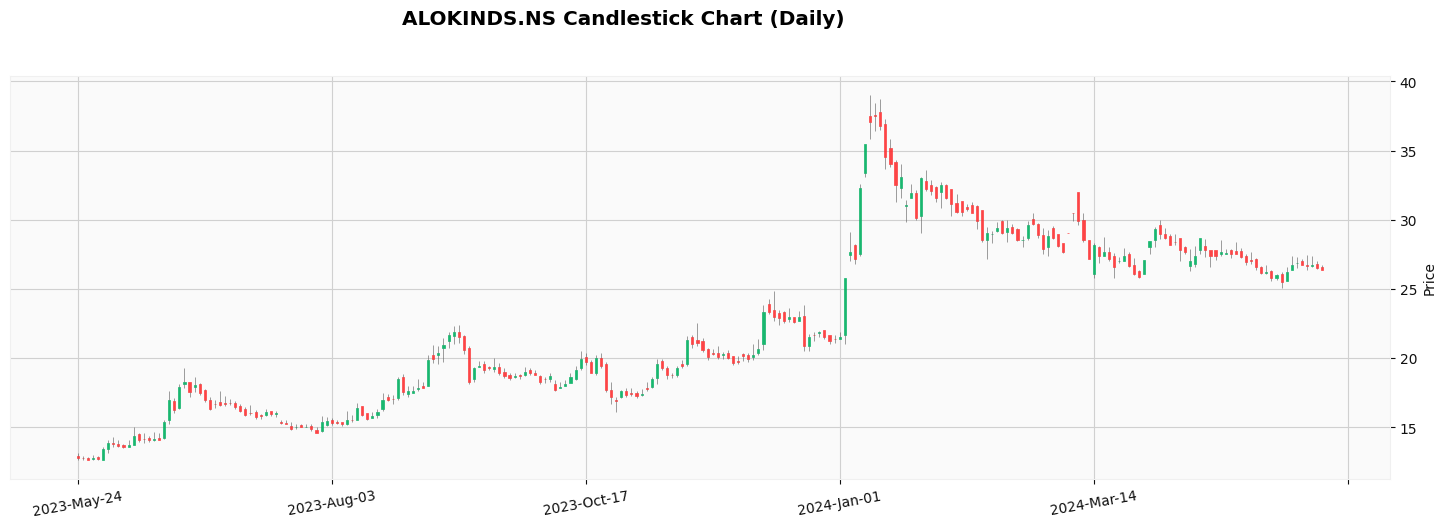

In [13]:
# Creating Candlestick Charts with mplfinance (alternative to Graph Objects above)

mpf.plot(
    hist, 
    xrotation=10,
    type='candle', 
    title=f"{yf_stock_symbol} Candlestick Chart (Daily)", 
    style='yahoo', 
    figscale = 1.0, 
    figratio = (1, 0.3)
)


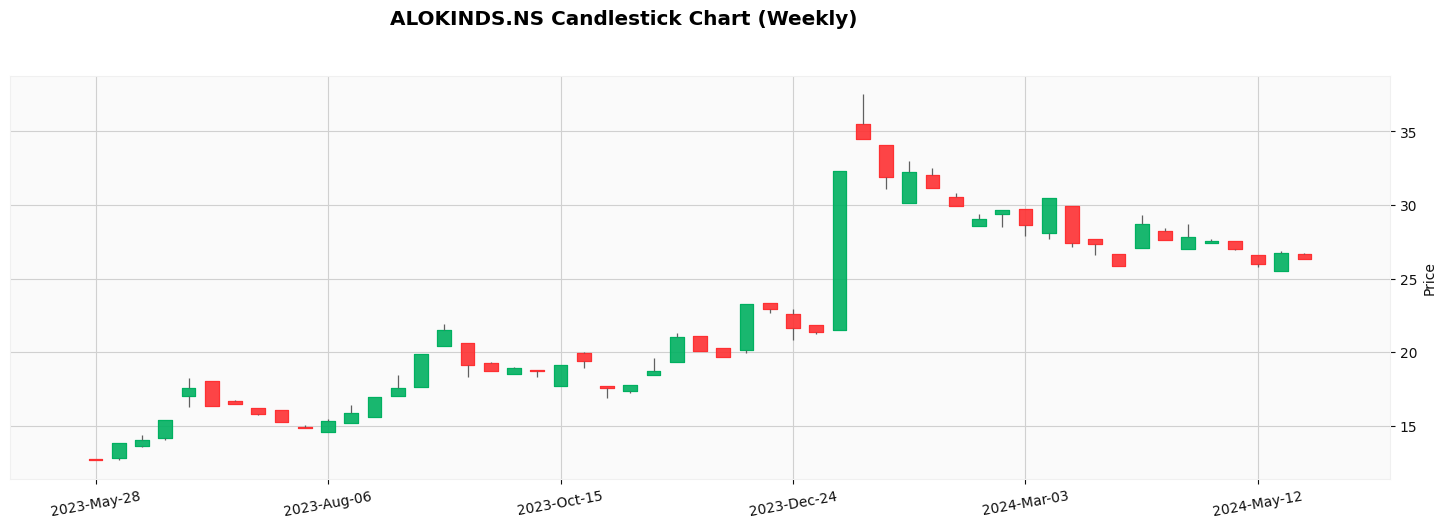

In [14]:
# Plotting Candlestick Charts at Different Timeframes

weekly_data = hist['Close'].resample('W').ohlc()


mpf.plot(
    weekly_data, 
    xrotation=10, 
    type='candle', 
    title=f"{yf_stock_symbol} Candlestick Chart (Weekly)", 
    style='yahoo', 
    figscale = 1.0, 
    figratio = (1, 0.3)
)


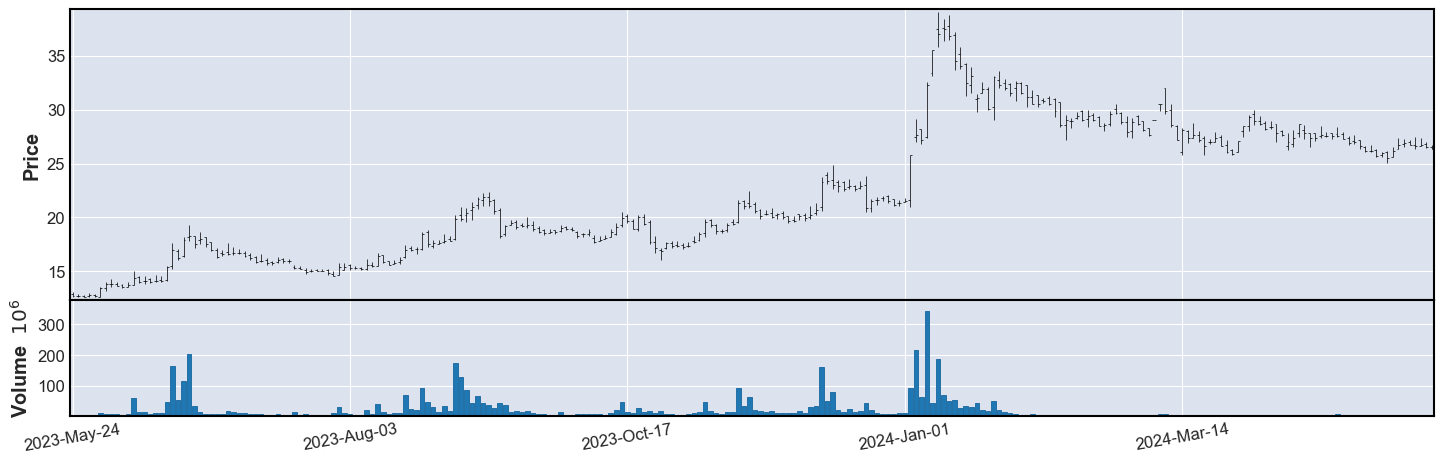

In [19]:
mpf.plot(
    hist, 
    xrotation=10, 
    volume=True, 
    tight_layout=True, 
    figscale=0.82,
    figratio = (1, 0.3)
)

In [20]:
# Using Libraries for Technical Indicators

# Calculate the Moving Average (MA)

hist['SMA_20'] = talib.SMA(hist['Close'], timeperiod=20)
hist['SMA_30'] = talib.SMA(hist['Close'], timeperiod=30)
hist.dropna(inplace=True)

In [21]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,SMA_30
Date,,,,,,,,,
2023-07-05 00:00:00+05:30,16.750000,17.250000,16.549999,16.700001,13614581,0.0,0.0,15.9875,15.056667
2023-07-06 00:00:00+05:30,16.750000,17.049999,16.600000,16.750000,10020079,0.0,0.0,16.1400,15.190000
2023-07-07 00:00:00+05:30,16.750000,16.900000,16.299999,16.450001,11145629,0.0,0.0,16.2425,15.313333
2023-07-10 00:00:00+05:30,16.549999,16.700001,16.100000,16.200001,9412933,0.0,0.0,16.3500,15.431667
2023-07-11 00:00:00+05:30,16.299999,16.450001,15.800000,15.900000,9417099,0.0,0.0,16.4375,15.535000


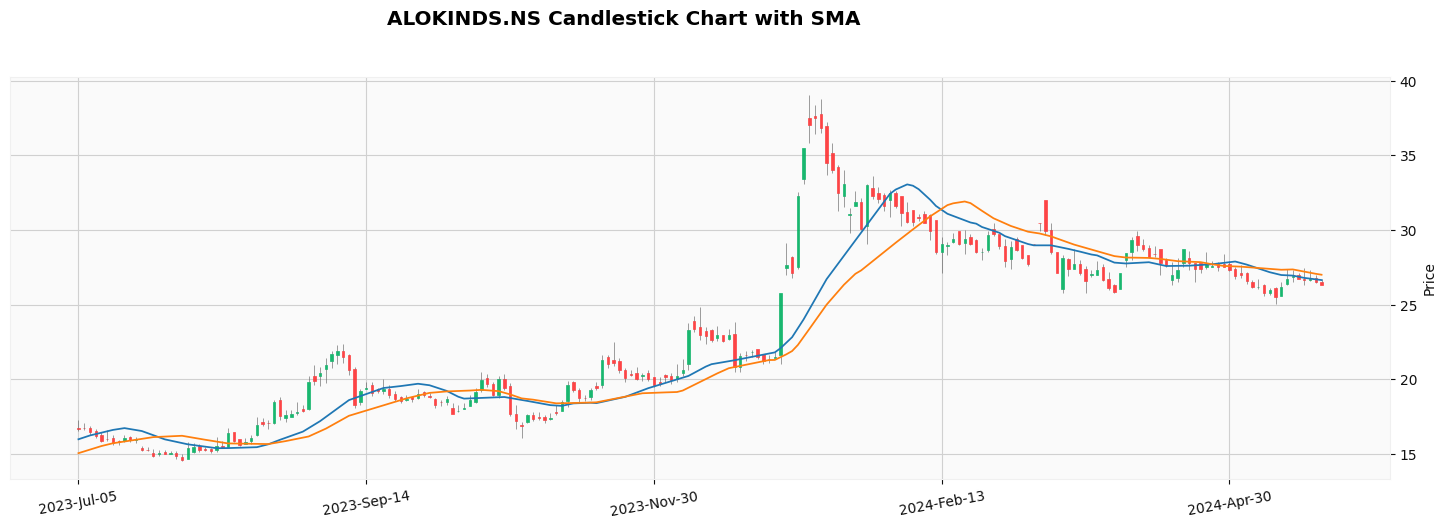

In [22]:
mpf.plot(
    hist, 
    addplot=[mpf.make_addplot(hist[['SMA_20','SMA_30']])], 
    xrotation=10, 
    type='candle',
    title=f"{yf_stock_symbol} Candlestick Chart with SMA",
    style='yahoo', 
    figscale = 1.0, 
    figratio = (1, 0.3)
)

# Time Series Forecasting with ARIMA

#### About ARIMA Models:
<pre>
The ARIMA stands for Autoregressive Integrated Moving Average. This model is a robust statistical technique utilized for forecasting time series data. It extends the capabilities of the ARMA (Autoregressive Moving Average) model and excels in managing diverse temporal patterns commonly found in time series data.
</pre>

#### Components of ARIMA Model:
<pre>
The ARIMA model is composed of three primary components, which are explicitly defined as parameters.

1) AutoRegressive (AR) Component (p-component): This element captures the correlation between an observation and several previous observations (lagged observations).
2) Integrated (I) Component (d-component): The integrated component is responsible for transforming raw observations in order to achieve stationarity in the time series.
3) Moving Average (MA) Component (q-component): This particular component represents the relationship between an observation and a residual error derived from a moving average model that is applied to previous observations (lagged observations).
</pre>

#### The ARIMA model is denoted as ARIMA(p,d,q), where:
<pre>
1) p: The quantity of delayed observations/lagged observations incorporated in the model for the autoregressive element. It measures the correlation between the current value of a time series and the values that came before it.
2) d: The degree of differencing implemented on the time series in order to achieve stationarity. For stationary data, the value of d is 0, whereas for seasonal data, the value of d is 1. The parameter d represents the integrated part of ARIMA. It is the number of times the series needs to be differenced to make it stationary.
3) q: The moving average component's window size for the moving average. It measures the correlation between the current value of the series and the errors from past predictions.
</pre>

In [23]:
# For the remainder of the task, we solely require the columns containing the 'Date' and 'Close' prices. 
# Therefore, let us proceed by selecting and advancing with both of these columns.

data = data[["Date", "Close"]]
print(data.head())

        Date  Close
0 2023-05-25  12.75
1 2023-05-26  12.65
2 2023-05-29  12.80
3 2023-05-30  12.70
4 2023-05-31  13.45


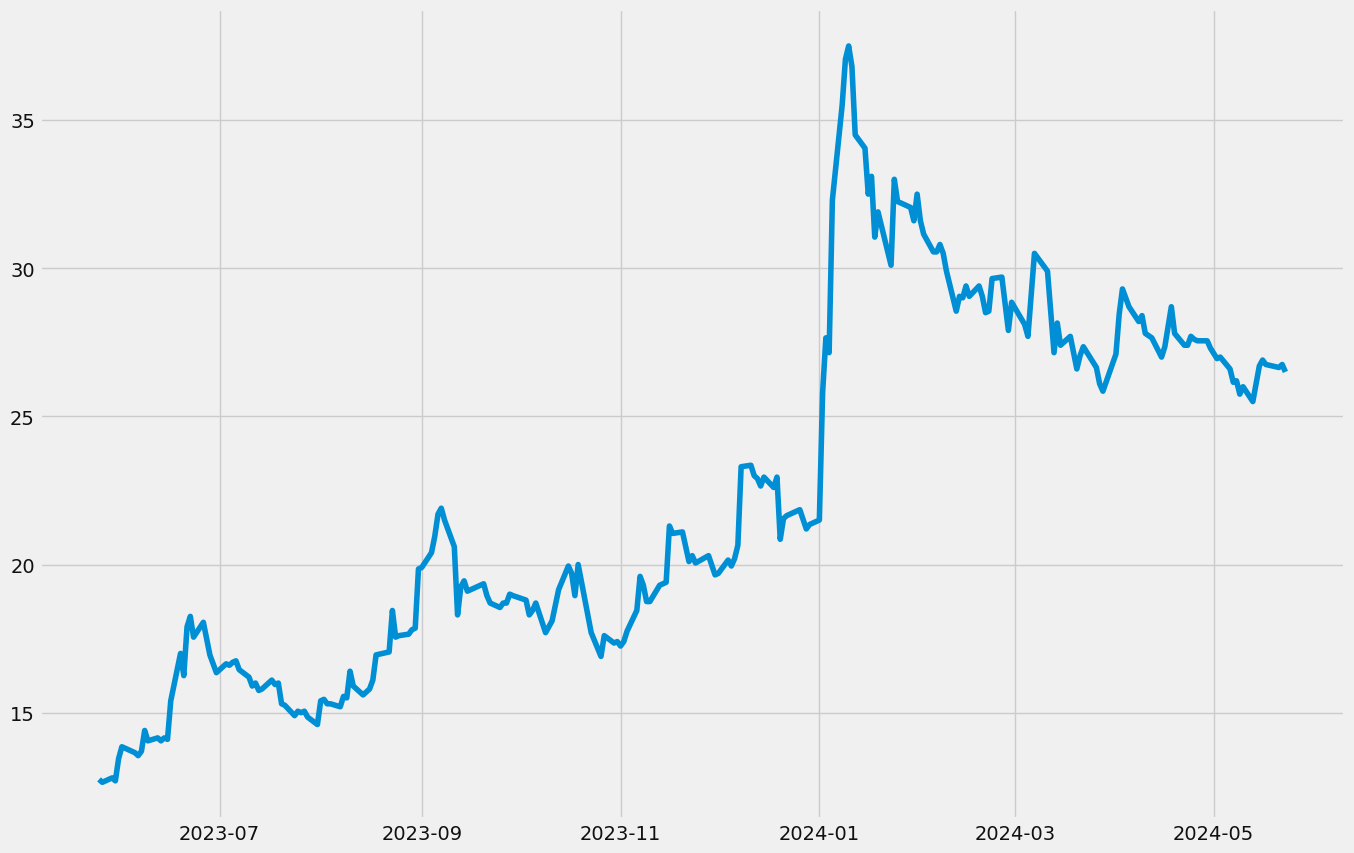

In [24]:
# plot the data and visualize the line profile
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

<Figure size 640x480 with 0 Axes>

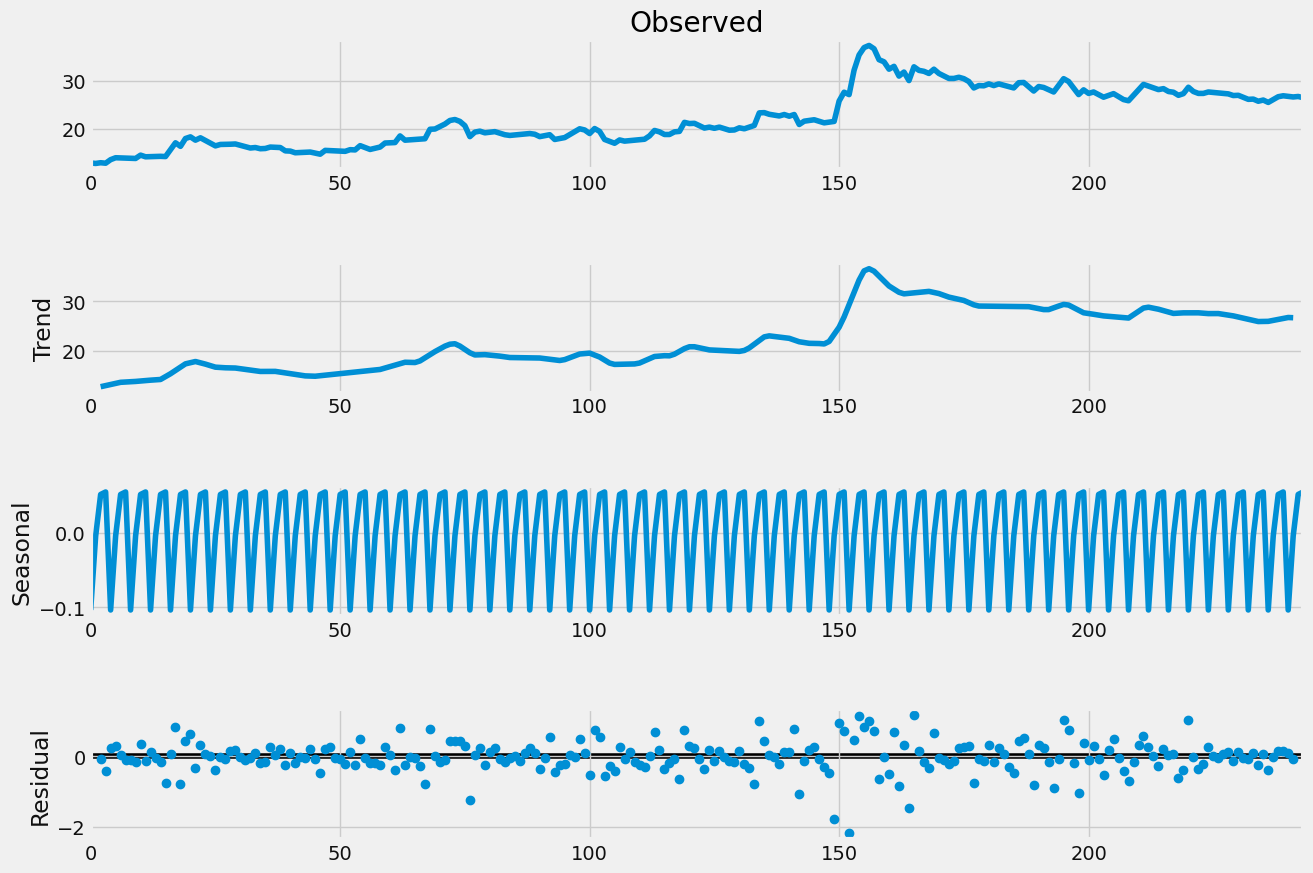

In [25]:
# Let's figure out whether our data is stationary or seasonal.

# result = seasonal_decompose(np.asarray(data["Close"]), model='multiplicative', period=4)
result = seasonal_decompose(np.asarray(data["Close"]), model='additive', period=4)
fig = plt.figure()
fig = result.plot()  
fig.set_size_inches(15, 10)

### It is looks like data is not stationary it is seasonal. 

<pre>
Seasonal decomposition is a method utilized to break down a time series into its fundamental elements, such as trend, seasonality, and residuals. This procedure entails dividing the time series data into these segments in order to gain a clearer insight into the inherent patterns and fluctuations.

It is crucial to specify whether the model is additive or multiplicative when utilizing the seasonal_decompose() function. Both models can yield outcomes, and it is of utmost importance to meticulously interpret the output according to the selected model.

It is essential to accurately model and forecast seasonal time series analysis by determining whether to utilize an additive or multiplicative decomposition method.

Additive Decomposition:
1) In the additive decomposition method, it is assumed that the seasonal variation is not influenced by the level of the time series.
2) The data without trend is adjusted to have a mean of 0, as adding zero does not alter the trend.
3) To achieve an additive decomposition, seasonal effects are normalized to have an average of 0.
4) It is assumed that the seasonal pattern estimates repeat annually.
5) The seasonal factors in additive decomposition are calculated by subtracting the trend estimates from the series.

Multiplicative Decomposition:
1) In the context of multiplicative decomposition, it is assumed that the seasonal variation is linked to the level of the time series.
2) The detrended data is standardized at 1, as multiplying the trend by 1 does not alter it.
3) To achieve a multiplicative decomposition, the seasonal effects are adjusted in such a way that their average becomes 1.
4) The seasonal component is presumed to remain constant from one year to another.
5) In the case of multiplicative decomposition, the seasonal factors are estimated by dividing the series by the trend values.

Determining Stationarity and Seasonality in Time Series Data:
1) A stationary time series is one whose properties do not depend on the time at which the series is observed.
2) A stationary time series has constant mean, variance, and autocorrelation structure over time.
3) A time series with a clear seasonal component is referred to as non-stationary.
4) Seasonality occurs when the pattern in a time series shows variation for a regular time interval, causing the variance to change over time.
5) The time series with trends, or with seasonality, are not stationary as the trend and seasonality will affect the value of the time series at different times.
</pre>

### As our data is seasonal, we should use 1 as the d value. We will use 'autocorrelation plot' to find the p value and for q value we will use 'partial autocorrelation plot'.


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

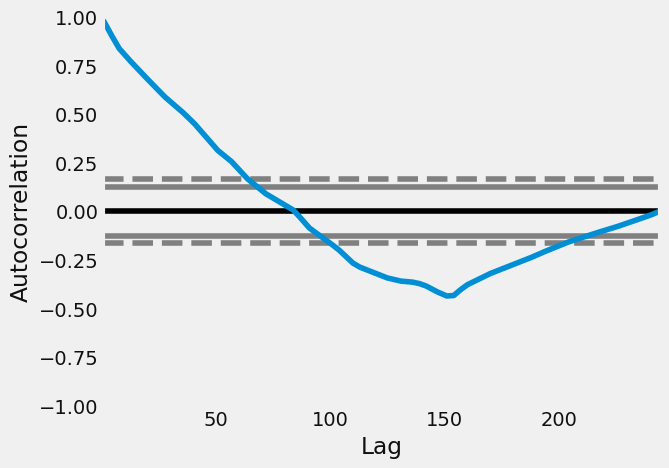

In [26]:
# Let's find the value of p:

pd.plotting.autocorrelation_plot(data["Close"])

The autocorrelation plot above shows a downward trend after the 5th line of the first boundary, indicating how to determine the p-value. Therefore, the p-value is 5.

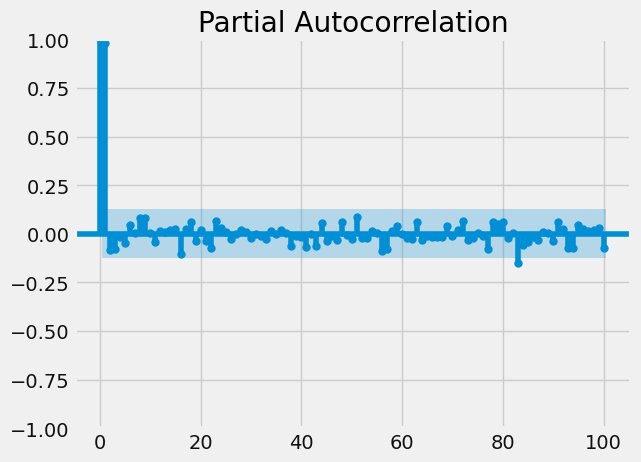

In [27]:
# Now let’s find the value of q (moving average)
plot_pacf(np.asarray(data["Close"]), lags=100, method='ywm')
plt.show()

In the partial autocorrelation plot above, it is evident that only two points are significantly distant from the rest. This observation aids in determining the value of q, which in this case is 2.

In [28]:
# alternative way to find p and q value while d = 1

result = {}
for p in range(5):
    for q in range(5):
        arma = sm.tsa.ARIMA(np.asarray(data['Close']), order=(p, 1, q))
        arma_fit = arma.fit()
        result[(p, q)] = arma_fit.aic

p, q = min(result, key=result.get)
print(p, q)

d:\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

d:\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

d:\mlenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

d:\mlenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



4 2


d:\mlenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [29]:
# Now let’s build an ARIMA model

p, d, q = 5, 1, 2

model = ARIMA(data["Close"], order=(p, d, q))  
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  244
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -300.183
Date:                Fri, 24 May 2024   AIC                            616.366
Time:                        17:35:37   BIC                            644.310
Sample:                             0   HQIC                           627.622
                                - 244                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2627      0.335      3.775      0.000       0.607       1.918
ar.L2         -0.4459      0.359     -1.241      0.215      -1.150       0.258
ar.L3         -0.0940      0.095     -0.985      0.3

In [30]:
# predictions = fitted.predict()
pred = model.predict(len(data), len(data)+20)


<Axes: >

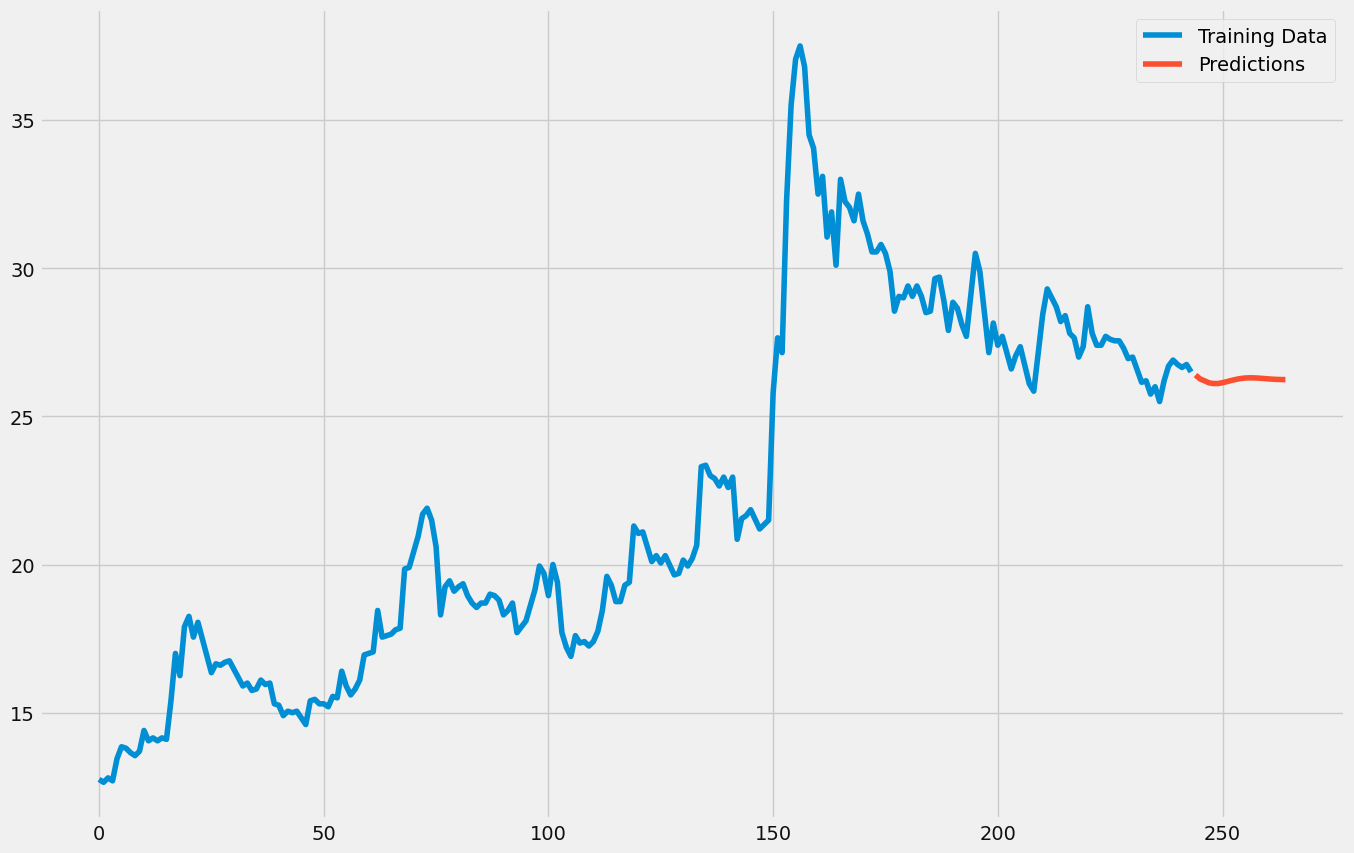

In [31]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
pred.plot(legend=True, label="Predictions")

The forecasted values are inaccurate due to the presence of seasonality in the data. ARIMA models are not suitable for effectively analyzing seasonal time series data. Therefore, let's explore the process of constructing a SARIMAX model.

# Time Series Forecasting with SARIMAX

In [32]:
# Now let’s build an SARIMAX model

# SARIMAX  -> Seasonal ARIMA with eXogenous regressors

model = sm.tsa.statespace.SARIMAX(data['Close'], order=(p, d, q), seasonal_order=(p, d, q, 12))
model = model.fit()

print(model.summary())

d:\mlenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  244
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -305.014
Date:                            Fri, 24 May 2024   AIC                            640.027
Time:                                    17:38:41   BIC                            691.663
Sample:                                         0   HQIC                           660.854
                                            - 244                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4837      0.401      1.205      0.228      -0.303       1.271
ar.L2          0.3830      0.437   

In [33]:
# Let us now forecast the upcoming stock prices by utilizing the SARIMAX model for the following 20 days.

pred = model.predict(len(data), len(data)+20)

<Axes: >

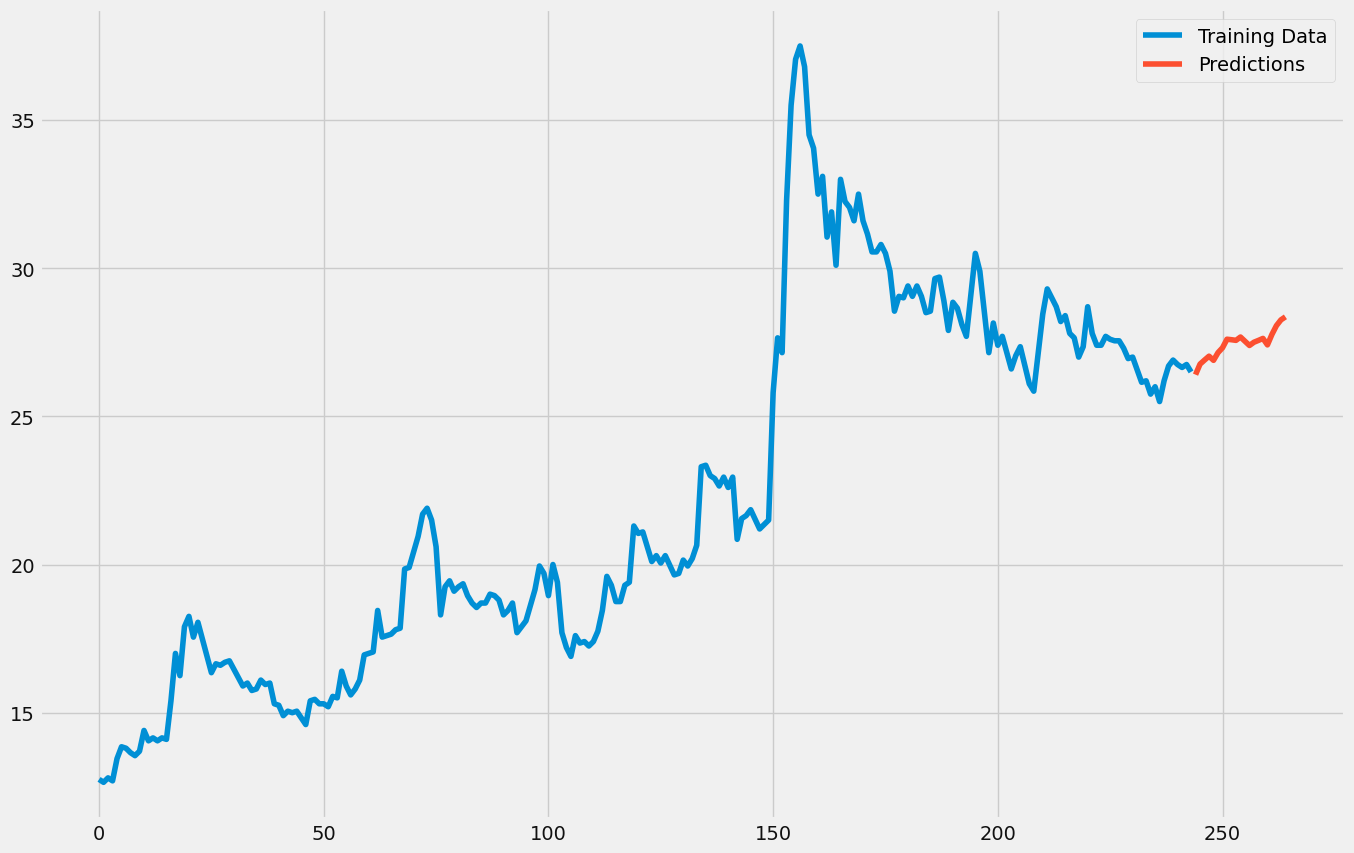

In [34]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
pred.plot(legend=True, label="Predictions")

#### ARIMA is a computational method employed to predict Time Series Data. In cases where the data remains constant, ARIMA is necessary; however, if the data exhibits seasonality, Seasonal ARIMA (SARIMA) / SARIMAX should be utilized.

References:

<pre>
https://www.kaggle.com/code/ahmadjalalmasood123/time-series-analysis-using-arima-model
https://thecleverprogrammer.com/2022/07/12/stock-market-analysis-using-python/
https://stackoverflow.com/questions/70223523/statsmodel-typeerror-fit-got-an-unexpected-keyword-argument-disp
https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
https://plotly.com/python/candlestick-charts/
https://thecleverprogrammer.com/2022/06/21/time-series-forecasting-with-arima/
https://stackoverflow.com/questions/62783633/how-to-interpret-plots-of-autocorrelation-and-partial-autocorrelation-using-pyth
https://medium.com/@kasperjuunge/yfinance-10-ways-to-get-stock-data-with-python-6677f49e8282
https://www.linkedin.com/pulse/financial-stock-data-gathering-extracting-nse-creating-shubham-gupta/
https://zerotomastery.io/blog/arima-sarima-sarimax-explained/
https://pypi.org/project/mplfinance/
</pre>